In [1]:
using LinearAlgebra  #####Son las paqueterias que uso, para instalar una paqueteria basta colocar Pkg.add("Nombre_de_la_paqueteria")
using Plots
using SpecialFunctions: gamma
using Random, Distributions
using StatsBase
using Alert

In [17]:
U(K::Float64,T::Float64)=[T/sqrt(K^2+T^2),0,K/sqrt(K^2+T^2)] #Es la función que da el eje de rotación dependiente de la curvatura y la torsión
ϕ(K::Float64,T::Float64,Δt::Float64)=Δt*sqrt(K^2+T^2) #Es la función que da el angulo de rotación

ψ0(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar el primer angulo  resultado de dos "matrices/cuaternios"

# Son las funciones para generar el primer eje resultado de dos "matrices/cuaternios"
w1x(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1])*csc(ψ0/2) 
w1y(ϕ0,ϕ1,u,w,ψ0)=((u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
w1z(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3])*csc(ψ0/2)


ψn(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar los otros angulos

# Son las funciones para generar los otros ejes resultado
wnx(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1]-(w[2]*u[3])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)
wny(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[2]+(u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
wnz(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3]+(w[2]*u[1])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)


wnz (generic function with 1 method)

In [18]:
#Acomodamos el eje y el angulo de rotacion en una matriz de euler-rodriguez

MatRot(ω,Ψ)=[ cos(Ψ)+ω[1]^2*(1-cos(Ψ)) ω[1]*ω[2]*(1-cos(Ψ))-ω[3]*sin(Ψ) ω[1]*ω[3]*(1-cos(Ψ))+ω[2]*sin(Ψ);
                ω[2]*ω[1]*(1-cos(Ψ))+ω[3]*sin(Ψ) cos(Ψ)+ω[2]^2*(1-cos(Ψ)) ω[2]*ω[3]*(1-cos(Ψ))-ω[1]*sin(Ψ);
                    ω[3]*ω[1]*(1-cos(Ψ))-ω[2]*sin(Ψ) ω[3]*ω[2]*(1-cos(Ψ))+ω[1]*sin(Ψ) cos(Ψ)+ω[3]^2*(1-cos(Ψ))]

MatRot (generic function with 1 method)

In [19]:
function serie_tiempo_v(PASO);
    #Generar ejes
    v=Array{Array{Float64,1},1}(undef,PASO)
    K=OUH(k0,γK,t[1:PASO],Δt,ηK,ctek)         # se obtiene un proceso de Ornstein–Uhlenbeck
    T=OUH(t0,γT,t[1:PASO],Δt,ηT,ctet)

    Un=U.(K,T)                                #Se obtiene los ejes infinitesimales
    ϕn=ϕ.(K,T,Δt)                             #Se obtiene los ángulos infinitesimales

    ω=Array{Array{Float64,1},1}(undef,PASO)   #se pondrán aquí los eigenejes en cada paso
    Ψ=Array{Float64,1}(undef,PASO)            #se pondrán aquí los eigenfases en cada paso
    ω[1]=Un[1]                                #se coloca el primer eje
    Ψ[1]=ϕn[1]                                #se coloca la primer fase

    v[1]=ω[1]     #Agregamos el primer eigen eje

    ψ1=ψ0(ϕn[1],ϕn[2],Un[1],Un[2])            #Se construye la segunda fase
    w=[w1x(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),       #Se construye el segundo eje
        w1y(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1z(ϕn[1],ϕn[2],Un[2],Un[1],ψ1)];
    ω[2]=w                                  #Se coloca el segundo eje
    Ψ[2]=ψ1                                 #Se coloca el segundo angulo

    v[2]=ω[2]   #Agregamos el segundo eigen eje

    for i=3:PASO                            #Agregamos LOS demas eigenejes
        ψ=ψn(ψ1,ϕn[i],Un[i],w)
        w=[wnx(ψ1,ϕn[i],Un[i],w,ψ),wny(ψ1,ϕn[i],Un[i],w,ψ),wnz(ψ1,ϕn[i],Un[i],w,ψ)]
        ω[i]=w
        Ψ[i]=ψ1
        ψ1=ψ
        v[i]=ω[i]
    end    
    return v
end

serie_tiempo_v (generic function with 1 method)

In [60]:
function covariance_S(X::Array{Float64,1},Y::Array{Float64,1})
    n=length(X)
    cov=0
    Xm=mean(X)
    Ym=mean(Y)
    for i=1:n
       @inbounds cov=(X[i]-Xm)*(Y[i]-Ym) + cov
    end
    return cov/n
end

covariance_S (generic function with 1 method)

In [21]:
function OUH(x0::Float64,γ::Float64,t::AbstractArray,Δt::Float64,η::Float64,cte::Float64=0.0) #Proceso de Ornstein–Uhlenbeck
    x=Vector{Float64}(undef, length(t)) #Definimos un vector lleno de basura para luego sobre escribir en el 
    x[1]=x0    #La primera entrada es la condicion inicial del Proceso de Ornstein–Uhlenbeck
    
    for i=1:length(t)-1                 #Usamos un for para poder hacer el proceso
        x0=x0-γ*Δt*(x0-cte)+(sqrt(2*η*Δt)*randn()) # Es el proceso de Ornstein–Uhlenbeck que depende del paso anterior 
        @inbounds x[1+i]=x0                 #@inbounds ignora si la lista tiene el tamaño adecuado y sobreescribimos en la lista basura
    end
    return x                          # Devolvemos la caminata de Ornstein–Uhlenbeck
end

OUH (generic function with 2 methods)

In [71]:
f(t)=angle(exp(im*sqrt(2)*k0*t))

f (generic function with 1 method)

In [72]:
function serie_tiempo_θ(PASO);     # Nos da la serie de tiempo de las eigenfases
    θ=Array{Float64,1}(undef,PASO)

    K=OUH(k0,γK,t[1:PASO],Δt,ηK,ctek)
    T=OUH(t0,γT,t[1:PASO],Δt,ηT,ctet)

    Un=U.(K,T)
    ϕn=ϕ.(K,T,Δt)

    ω=Array{Array{Float64,1},1}(undef,PASO)
    Ψ=Array{Float64,1}(undef,PASO)
    ω[1]=Un[1]
    Ψ[1]=ϕn[1]
    
    θ[1]=Ψ[1]     #Agregamos la primer eigenfase
    
    ψ1=ψ0(ϕn[1],ϕn[2],Un[1],Un[2])
    w=[w1x(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1y(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1z(ϕn[1],ϕn[2],Un[2],Un[1],ψ1)];
    ω[2]=w
    Ψ[2]=ψ1
    
    θ[2]=Ψ[2]     #Agregamos la segunda eigenfase
    
    for i=3:PASO   #Agregamos LOS demas eigenfases
        ψ=ψn(ψ1,ϕn[i],Un[i],w)
        w=[wnx(ψ1,ϕn[i],Un[i],w,ψ),wny(ψ1,ϕn[i],Un[i],w,ψ),wnz(ψ1,ϕn[i],Un[i],w,ψ)]
        ω[i]=w
        Ψ[i]=ψ1
        ψ1=ψ
        θ[i]=Ψ[i]
    end
    
    return θ
end

serie_tiempo_θ (generic function with 1 method)

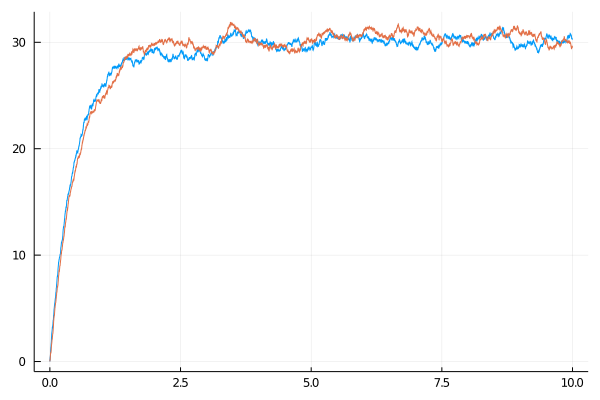

In [22]:
k0=0.01
t0=0.01

γK=2.0
γT=2.0

ηK=1.0
ηT=1.0

N=10.0

Δt=0.001

t=0:Δt:N

ctek=30.0
ctet=30.0

K=OUH(k0,γK,t,Δt,ηK,ctek)
T=OUH(t0,γT,t,Δt,ηT,ctet)
plot(t,K,legend=false)
plot!(t,T,legend=false)

In [23]:
A=[]
for i=1:500
    push!(A,OUH(k0,γK,t,Δt,ηK,ctek))
end

In [24]:
OH=Float64[]
for i=1000:length(t)
    a=covariance_S(transpose(hcat(A...))[:,1000],transpose(hcat(A...))[:,i])
    push!(OH,a)
end

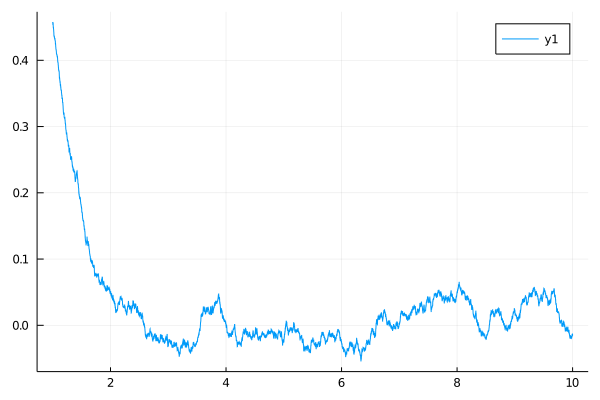

In [25]:
plot(t[1000:length(t)],OH)

## Eigenejes

El resultado analítico bajo la hipotesis de que la curvatura y la torsión son constantes $\kappa=\tau=\kappa_{o}$ de los eigenejes $w(t)$ de la matriz $\mathcal{R}(t)$ es

$$
w(t)=\left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right)
$$

pero también puede reescribirse (junto con las eigenfases) como una onda cuadrada

$$
w(t)=
\left\{
	\begin{array}{lll}
		\left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right)  & \mbox{si } t \in \left[0,\frac{2\pi}{\sqrt{2}v_{a}\kappa_{o}}\right) \\
        -\left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) & \mbox{si } t \in \left[\frac{2\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{4\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)\\
        \left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) & \mbox{si } t \in \left[\frac{4\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{6\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)\\
        \vdots\\
        -\left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) & \mbox{si } t \in \left[\frac{2n\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{2(n+1)\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)\\
        \left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) & \mbox{si } t \in \left[\frac{2(n+1)\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{2(n+2)\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)
	\end{array}
\right.
$$

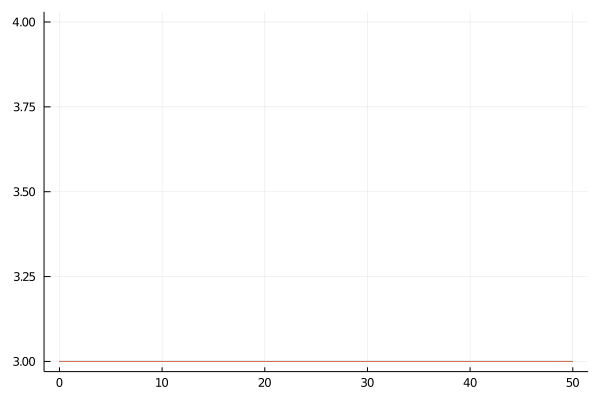

In [133]:
k0=3.0
t0=3.0

γK=0.0
γT=0.0

ηK=0.0
ηT=0.0

N=50.0

Δt=0.001

t=0:Δt:N

ctek=3.0
ctet=3.0

K=OUH(k0,γK,t,Δt,ηK,ctek)
T=OUH(t0,γT,t,Δt,ηT,ctet);
plot(t,K,legend=false)
plot!(t,T,legend=false)

In [134]:
PASO=5001#length(t)

5001

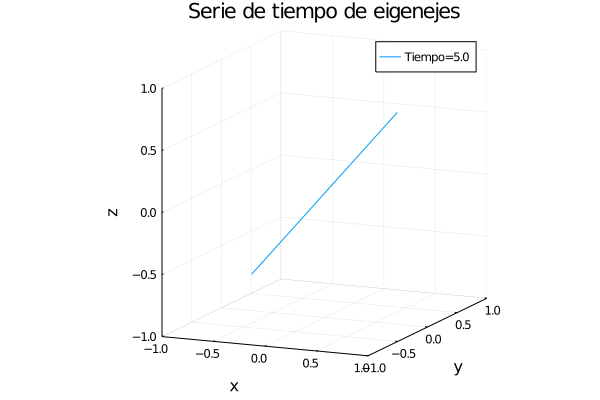

In [135]:
v=serie_tiempo_v(PASO);
plot(transpose(hcat(v...))[:,1],transpose(hcat(v...))[:,2],transpose(hcat(v...))[:,3],markersize=1,xlims=(-1,1),ylims=(-1,1),zlims=(-1,1)
    ,aspect_ratio=:equal,xlabel="x",ylabel="y",zlabel="z",label="Tiempo=$(t[PASO])",markerstrokewidth=0
        ,title="Serie de tiempo de eigenejes")

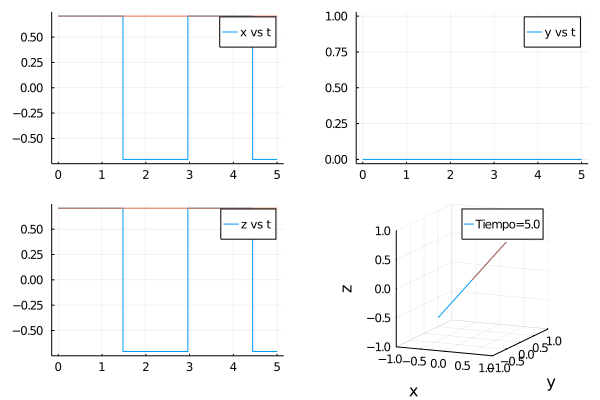

In [159]:

l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=plot(t[1:PASO],transpose(hcat(v...))[:,1],label="x vs t")
    plot!(t[1:PASO],(1/sqrt(2))*ones(length(t[1:PASO])),label="")
Q2=plot(t[1:PASO],transpose(hcat(v...))[:,2],label="y vs t")
Q3=plot(t[1:PASO],transpose(hcat(v...))[:,3],label="z vs t")
    plot!(t[1:PASO],(1/sqrt(2))*ones(length(t[1:PASO])),label="")
Q4=plot(transpose(hcat(v...))[:,1],transpose(hcat(v...))[:,2],transpose(hcat(v...))[:,3],markersize=1,xlims=(-1,1),ylims=(-1,1),zlims=(-1,1)
    ,aspect_ratio=:equal,xlabel="x",ylabel="y",zlabel="z",label="Tiempo=$(t[PASO])",markerstrokewidth=0)
    plot!([0,1/sqrt(2)],[0,0],[0,1/sqrt(2)],label="")
plot(Q1,Q2,Q3,Q4,layout=l)

In [160]:
savefig("./serie_de_tiempo_eigenejes.png")

In [137]:
t[50001]


50.0

In [138]:
PASO0=1
Step=10
PASOf=6001#length(t)
tiradas=500

500

In [139]:
A=[]   # Va a ser un array donde A[Son las tiradas][Son los eigen ejes #de PASOS]
for i=1:tiradas
    push!(A,serie_tiempo_v(length(t)))
end

In [140]:
m=Float64[]
for j=PASO0:Step:PASOf
    a=Float64[]
    for i=1:tiradas
        push!(a,dot(A[i][PASO0],A[i][j]))
    end
    push!(m,mean(a))
end

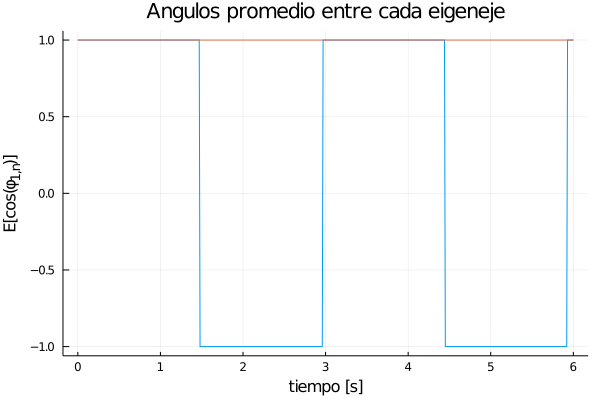

In [163]:
plot(t[PASO0:Step:PASOf],m, title="Angulos promedio entre cada eigeneje",xlabel="tiempo [s]",ylabel="E[cos\\(\\phi_{$(PASO0),n}\\)]",
    label="")#"D_{\\kappa}=D_{\\tau}=$(ηK)")
plot!(t[PASO0:Step:PASOf],ones(length(t[PASO0:Step:PASOf])),label="")

In [164]:
savefig("./PROMEDIO_EJES_ANGULO_determinista.png")

## Eigenfases

El resultado analítico bajo la hipotesis de que la curvatura y la torsión son constantes $\kappa=\tau=\kappa_{o}$ de lss eigenfases $\psi(t)$ de la matriz $\mathcal{R}(t)$ es

$$
\psi(t)=\sqrt{2}v_{a}\kappa_{o}t
$$

donde $\psi(t)\in[-\pi,\pi]$ lo que hace que la gráfica sea perriodica, con periodicidad $2\pi$, entonces la función realmente es

$$
\psi(t)=
\left\{
	\begin{array}{lll}
		\sqrt{2}v_{a}\kappa_{o}t  & \mbox{si } t \in \left[0,\frac{\pi}{\sqrt{2}v_{a}\kappa_{o}}\right) \\
        \sqrt{2}v_{a}\kappa_{o}t -2\pi & \mbox{si } t \in \left[\frac{\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{3\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)\\
        \vdots\\
        \sqrt{2}v_{a}\kappa_{o}t -2n\pi & \mbox{si } t \in \left[\frac{(2n-1)\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{(2n+1)\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)
	\end{array}
\right.
$$


donde $n=1,2,3,\dots$ pero también se puede redefinir con  $\psi(t)\in[0,2\pi]$ como

$$
\psi(t)=
\left\{
	\begin{array}{lll}
		\sqrt{2}v_{a}\kappa_{o}t  & \mbox{si } t \in \left[0,\frac{2\pi}{\sqrt{2}v_{a}\kappa_{o}}\right) \\
        -\sqrt{2}v_{a}\kappa_{o}t +4\pi & \mbox{si } t \in \left[\frac{2\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{4\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)\\
        \sqrt{2}v_{a}\kappa_{o}t -4\pi & \mbox{si } t \in \left[\frac{4\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{6\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)\\
        \vdots\\
        -\sqrt{2}v_{a}\kappa_{o}t +4n\pi & \mbox{si } t \in \left[\frac{2n\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{2(n+1)\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)\\
        \sqrt{2}v_{a}\kappa_{o}t -4n\pi & \mbox{si } t \in \left[\frac{2(n+1)\pi}{\sqrt{2}v_{a}\kappa_{o}},\frac{2(n+2)\pi}{\sqrt{2}v_{a}\kappa_{o}}\right)
	\end{array}
\right.
$$

  0.013150 seconds (106.97 k allocations: 3.045 MiB)


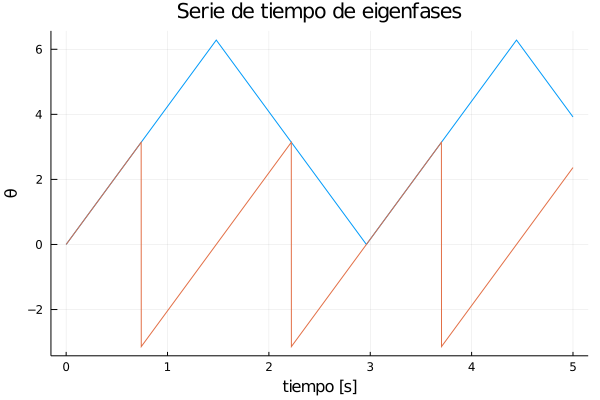

In [148]:
@time a=serie_tiempo_θ(PASO)
plot(t[1:PASO],a,label="",
    title="Serie de tiempo de eigenfases",xlabel="tiempo [s]",ylabel="\\theta")
plot!(t[1:PASO],f.(t[1:PASO]),label="")

In [149]:
savefig("./serie_de_tiempo_eigenfases.png")

In [126]:

tiradas=500
A=[]
for i=1:tiradas
    push!(A,serie_tiempo_θ(length(t)))
end

In [127]:
PASO0=1000
Step=10
PASOf=length(t)


50001

In [128]:
@time covariance_S(transpose(hcat(A...))[:,1000],transpose(hcat(A...))[:,1001])

  0.136861 seconds (20 allocations: 381.494 MiB, 15.64% gc time)


0.0

In [129]:
length(PASO0:Step:PASOf)

4901

In [130]:
@time begin
    OH=Float64[]
    #nor=covariance_S(transpose(hcat(A...))[:,PASO0],transpose(hcat(A...))[:,PASO0])
    for i=PASO0:Step:PASOf
        a=covariance_S(transpose(hcat(A...))[:,PASO0],transpose(hcat(A...))[:,i])#/nor
        push!(OH,a)
    end
end

734.364950 seconds (117.64 k allocations: 1.783 TiB, 22.34% gc time)


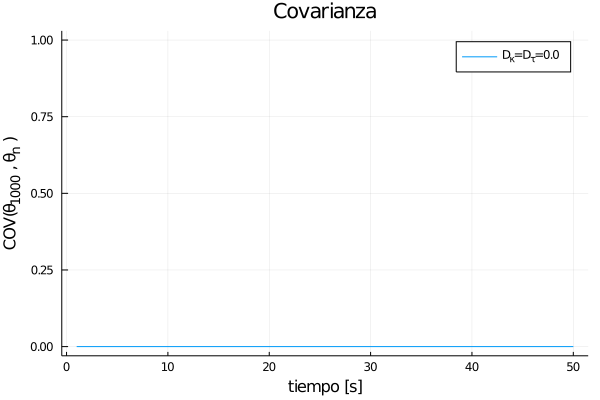

In [131]:
plot(t[PASO0:Step:PASOf],OH,title="Covarianza",xlabel="tiempo [s]",ylabel="COV\\(\\theta_{$(PASO0)} , \\theta_{n} \\)",
    label="D_{\\kappa}=D_{\\tau}=$(ηK)")

In [ ]:
savefig("./COVARIANCE_EIG_Angulos_determinista.png")